In [267]:
import numpy as np
import pandas as pd

from keras.layers import RepeatVector
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import matplotlib.pyplot as plt
%matplotlib inline

In [268]:
np.random.seed(23)

In [269]:
df = pd.read_csv('df_merged.csv', parse_dates=['days'], index_col='days')

In [270]:
df.sample(5)

,dt,cur_time_in_gmt,cpu_utilization_pctg,hour,cpu_utilization_pctg_extrapolated,is_extrapolated
days,,,,,,
2017-07-21 01:00:00,7/20/2017,7/21/2017 1:00,50.833,1,50.833,False
2017-04-06 21:00:00,4/6/2017,4/6/2017 21:00,48.611,21,48.611,False
2017-05-12 21:00:00,5/12/2017,5/12/2017 21:00,58.889,21,58.889,False
2017-04-17 07:00:00,4/17/2017,4/17/2017 7:00,26.382,7,26.382,False
2017-04-04 07:00:00,4/4/2017,4/4/2017 7:00,34.167,7,34.167,False


In [271]:
df = df[['cpu_utilization_pctg_extrapolated']]
df.columns = ['cpu_util_pctg']
df.sample(5)

,cpu_util_pctg
days,
2017-04-15 03:00:00,61.066
2017-06-10 20:00:00,46.125
2017-07-06 03:00:00,55.833
2017-05-26 08:00:00,31.389
2017-05-02 23:00:00,33.629


In [272]:
from sklearn.preprocessing import StandardScaler

# Normalize the  data (center around 0 and scale to remove the variance).
scaler = StandardScaler()
df['cpu_util_pctg'] = scaler.fit_transform(df['cpu_util_pctg'].values.reshape(-1, 1))

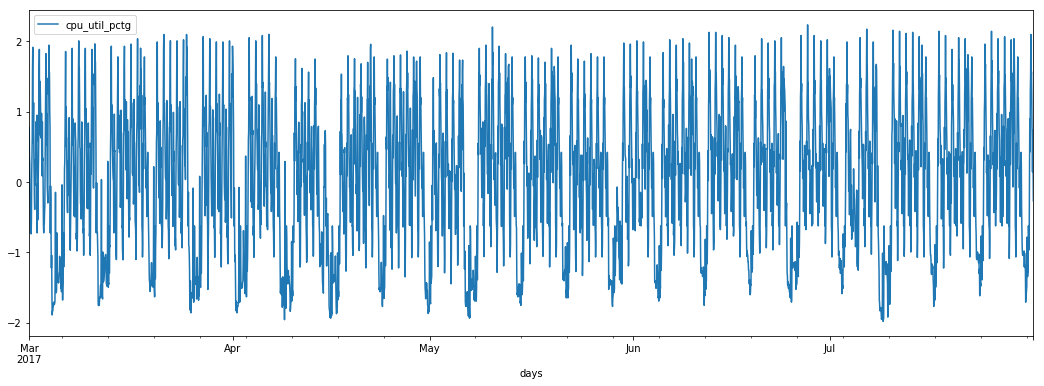

In [273]:
df.plot(figsize=(18,6));

In [274]:
len(df)

3672

In [275]:
signal_train = df['2017-03-01':'2017-05-31'].values
signal_valid = df['2017-06-01':'2017-06-30'].values
signal_test = df['2017-07-01':'2017-07-31'].values

In [276]:
window_length = 48

In [277]:
train_windows = []

In [278]:
for window_start in range(0, len(signal_train) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(signal_train[window_range])
    train_windows.append(window)

In [279]:
len(train_windows)

2161

In [280]:
len(signal_test)

744

In [281]:
#x_train = np.expand_dims(np.array(train_windows), axis=2)
#x_train.shape

In [282]:
x_train = np.array(train_windows)
x_train.shape

(2161, 48, 1)

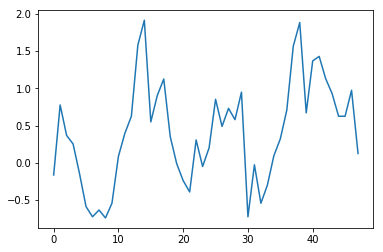

In [283]:
plt.plot(train_windows[0]);

In [284]:
valid_windows = []

In [285]:
for window_start in range(0, len(signal_valid) - window_length + 1):
    window_end = window_start + window_length
    window_range = range(window_start, window_end)
    window = list(signal_valid[window_range])
    valid_windows.append(window)

In [286]:
#x_valid = np.expand_dims(np.array(valid_windows), axis=2)
#x_valid.shape

In [287]:
x_valid = np.array(valid_windows)
x_valid.shape

(673, 48, 1)

In [288]:
hidden_dim = 24
batch_size = 168
epochs = 50
select_only_last_state = False

In [289]:
m = Sequential()
if select_only_last_state:
    m.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=False))
    m.add(RepeatVector(window_length))
else:
    m.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=True))
m.add(Dropout(rate=0.1))
m.add(LSTM(1, return_sequences=True, activation='linear'))
m.compile(loss='mse', optimizer='adam')

In [290]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 24)                2496      
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 48, 24)            0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 48, 24)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 48, 1)             104       
Total params: 2,600
Trainable params: 2,600
Non-trainable params: 0
_________________________________________________________________


In [291]:
history = m.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, x_valid), shuffle=False).history

Train on 2161 samples, validate on 673 samples
Epoch 1/50
2161/2161 [==============================] - 4s - loss: 1.0463 - val_loss: 0.8852
Epoch 2/50
2161/2161 [==============================] - 1s - loss: 0.9533 - val_loss: 0.8504
Epoch 3/50
2161/2161 [==============================] - 2s - loss: 0.9297 - val_loss: 0.8439
Epoch 4/50
2161/2161 [==============================] - 2s - loss: 0.9183 - val_loss: 0.8453
Epoch 5/50
2161/2161 [==============================] - 2s - loss: 0.9185 - val_loss: 0.8302
Epoch 6/50
2161/2161 [==============================] - 1s - loss: 0.8939 - val_loss: 0.8250
Epoch 7/50
2161/2161 [==============================] - 1s - loss: 0.8837 - val_loss: 0.8161
Epoch 8/50
2161/2161 [==============================] - 2s - loss: 0.8806 - val_loss: 0.7961
Epoch 9/50
2161/2161 [==============================] - 1s - loss: 0.8656 - val_loss: 0.7777
Epoch 10/50
2161/2161 [==============================] - 1s - loss: 0.8244 - val_loss: 0.7391
Epoch 11/50
2161/2161 

In [292]:
pred_x_valid = m.predict(x_valid)

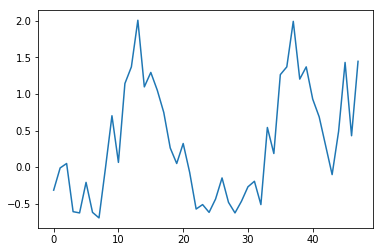

In [293]:
plt.plot(x_valid[1])

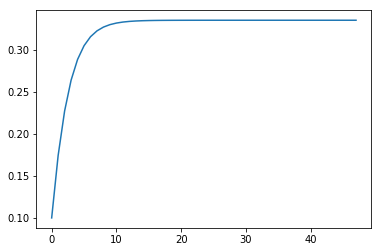

In [294]:
plt.plot(pred_x_valid[1])